In [1]:
#!pip install torch torchvision
!pip install torch-geometric
!pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121
#!pip install detectron2==0.6


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00


In [2]:
# Install PyYAML (if not already installed)
#!python -m pip install pyyaml==5.1

# Clone the Detectron2 repository
!git clone https://github.com/facebookresearch/detectron2.git

# Install required dependencies from Detectron2's setup.py
import distutils.core
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}

# Add Detectron2 to Python's path
import sys, os
sys.path.insert(0, os.path.abspath('./detectron2'))

# Alternatively, you can directly install Detectron2 using pip (not recommended for Colab):
# !python -m pip install git+https://github.com/facebookresearch/detectron2.git


Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 15837 (delta 29), reused 12 (delta 12), pack-reused 15783 (from 3)
Receiving objects: 100% (15837/15837), 6.40 MiB | 9.17 MiB/s, done.
Resolving deltas: 100% (11536/11536), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00

In [3]:
# --- Import Required Libraries ---
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from google.colab.patches import cv2_imshow  # For displaying images in Colab

model_final_280758.pkl: 167MB [00:02, 80.8MB/s]                          
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


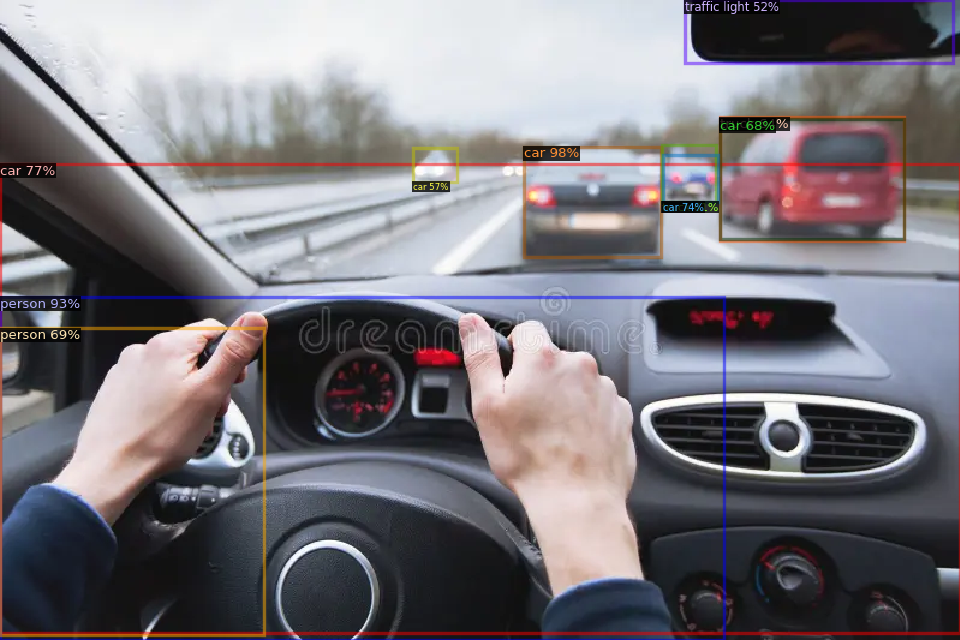

In [4]:
# --- Step 1: Object Detection using Detectron2 ---
# Load the pre-trained model for object detection
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for detection
predictor = DefaultPredictor(cfg)

# Load an image
image_path = "/content/car distance.webp"  # Replace with your image path
image = cv2.imread(image_path)

# Run object detection
outputs = predictor(image)
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the detected objects using cv2_imshow (Colab compatible)
cv2_imshow(v.get_image()[:, :, ::-1])

# Extract detected objects and their labels
detected_objects = outputs["instances"].to("cpu")
labels = detected_objects.pred_classes  # Object labels
boxes = detected_objects.pred_boxes

In [5]:
# --- Step 2: Create Scene Graph with PyTorch Geometric ---
# One-hot encode the labels to create node features
num_nodes = len(labels)
num_classes = labels.max().item() + 1  # Number of unique labels
node_features = torch.zeros((num_nodes, num_classes))
node_features[torch.arange(num_nodes), labels] = 1

# Define edges (e.g., connecting all detected objects)
edges = []
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        edges.append([i, j])  # Connect each object with every other object

edges = torch.tensor(edges, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]

# Create the graph data object
data = Data(x=node_features, edge_index=edges)

In [6]:
# --- Step 3: Graph Neural Network for Scene Graph Reasoning ---
class SceneGraphNetwork(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SceneGraphNetwork, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x

# Initialize the model
in_channels = num_classes  # Input features (one-hot encoded classes)
hidden_channels = 64  # Hidden layer size
out_channels = 128  # Output feature size
model = SceneGraphNetwork(in_channels, hidden_channels, out_channels)

# Apply GNN model on the graph to reason over the scene
output = model(data)

In [7]:
# --- Step 4: Integrate Knowledge Base for Rule-Based Reasoning ---
# Example: Define some knowledge base rules
knowledge_base = {
    "close": "If object A is close to object B, increase your distance before it intersect.",
    "supports": "If object A is on top of object B, object B supports object A.",
}

# Define a function for reasoning based on the object relationships
def reason_with_knowledge_base(output, edges, knowledge_base):
    # Assuming each node has a label indicating the object type
    for edge in edges.t():  # Transpose edges for iteration
        object_A = edge[0].item()
        object_B = edge[1].item()

        # Example rule-based reasoning: "close" or "supports" based on conditions
        if abs(object_A - object_B) < 5:  # Simplified condition
            print(f"Rule: {knowledge_base['close']} - Object {object_A} and Object {object_B} are close.")

        if object_A == 1 and object_B == 2:  # Arbitrary rule for demonstration
            print(f"Rule: {knowledge_base['supports']} - Object {object_B} supports Object {object_A}.")

# Call the reasoning function
reason_with_knowledge_base(output, edges, knowledge_base)


Rule: If object A is close to object B, increase your distance before it intersect. - Object 0 and Object 1 are close.
Rule: If object A is close to object B, increase your distance before it intersect. - Object 0 and Object 2 are close.
Rule: If object A is close to object B, increase your distance before it intersect. - Object 0 and Object 3 are close.
Rule: If object A is close to object B, increase your distance before it intersect. - Object 0 and Object 4 are close.
Rule: If object A is close to object B, increase your distance before it intersect. - Object 1 and Object 2 are close.
Rule: If object A is on top of object B, object B supports object A. - Object 2 supports Object 1.
Rule: If object A is close to object B, increase your distance before it intersect. - Object 1 and Object 3 are close.
Rule: If object A is close to object B, increase your distance before it intersect. - Object 1 and Object 4 are close.
Rule: If object A is close to object B, increase your distance befor